In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

In [3]:
data_dir = '../data/'
f_pfx = 'MERFISH'
fn_coord = data_dir + '{}_coord.csv'.format(f_pfx)
fn_expr = data_dir + '{}_expr.csv'.format(f_pfx)
data = pd.read_csv(fn_expr, index_col=0)
coor = pd.read_csv(fn_coord, index_col=0)

In [4]:
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
fileName = ddir + "/data/MERFISH/scGCO_results/MERFISH_result_df.csv"
result_df = pd.read_csv(fileName, index_col=0)
print(result_df.shape)
fdr05 = result_df[result_df.fdr < 0.05].sort_values(by=['fdr'])
print('scgco rejects {} genes'.format(fdr05.shape[0]))
de = ddir + "/data/MERFISH/spatialDE_results/middle_final_results.csv"
counts_de = pd.read_csv(de,index_col=0)
counts_de=counts_de[counts_de.qval<0.05]
counts_de=counts_de[counts_de.g.values != 'log_total_count']
print('spatialde rejects {} genes'.format(counts_de.shape[0]))

(140, 1052)
scgco rejects 84 genes
spatialde rejects 91 genes


In [13]:
from main_methods import select_spatial_genes
from matplotlib_venn import venn2,venn3
from io_utils import save_data_to_file

# run our method
alpha= 0.05
knn = 5
n_perm = 10000
pvals, rej_idx = select_spatial_genes(coor.values, data.values, 
                                      knn=knn, alpha=alpha, n_perm=n_perm)
ours = data.columns[rej_idx]
reject = np.array([False] * len(pvals))
reject[rej_idx] = True
result = pd.DataFrame({'pvalue': pvals, 'reject': reject, 'geneID':data.columns})
# save result to file
fn =  ddir+'/data/MERFISH/our_results/MERFISH_result_k{}_p{}.csv'.format(knn, n_perm)
print(fn)
save_data_to_file(result, fn, 'csv')        

print(ours.shape)
gsets = {
        'scGCO': set(fdr05.index.values),
        'SpatialDE': set(counts_de.g.values),
        'ours': set(data.columns[rej_idx])
    }

/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MERFISH/our_results/MERFISH_result_k5_p100000.csv
(128,)


In [45]:
df_res = pd.DataFrame({'gene': data.columns, 
                       'negative': data.columns.str.startswith('Blank'), 
                       'pvalue_ours': pvals})
df_res.index = df_res['gene']
neg_sets = {}
for met in gsets:
    gset = gsets[met]
    rej = pd.Series([False] * df_res.shape[0], index=df_res.gene)
    rej[gsets[met]] = True
    df_res['rej_{}'.format(met)] = rej
    ndf = df_res.loc[df_res['negative']]
    neg_sets[met] = set(ndf.loc[ndf['rej_{}'.format(met)]]['gene'])
df_res.loc[df_res['negative']]

,gene,negative,pvalue_ours,rej_scGCO,rej_SpatialDE,rej_ours
gene,,,,,,
Blank-1,Blank-1,True,0.003200,True,True,True
Blank-10,Blank-10,True,0.005000,True,False,True
Blank-2,Blank-2,True,0.018898,True,False,True
Blank-3,Blank-3,True,0.170483,False,False,False
Blank-4,Blank-4,True,0.000100,True,False,True
Blank-5,Blank-5,True,0.003700,True,True,True
Blank-6,Blank-6,True,0.000100,False,True,True
Blank-7,Blank-7,True,0.050995,False,False,False
Blank-8,Blank-8,True,0.000400,True,True,True


In [56]:
# plot the negative controls
from plot_utils import plot_multiple_scatter_continuous, plot_scatter_continuous
cols =  data.columns
blank_ids = cols[cols.str.startswith('Blank')]
print('Number of blank ids: {}'.format(len(blank_ids)))
min_pval = min(df_res['pvalue_ours'])
most_rej = df_res.loc[df_res['pvalue_ours']==min_pval] # .sort_values('pvalue_ours').head(80)
print('{} out of {} strongly rejected by SpatialDE'.format(
    np.sum(most_rej['rej_SpatialDE']), most_rej.shape[0]))
print('{} out of {} strongly rejected by scGCO'.format(
    np.sum(most_rej['rej_scGCO']), most_rej.shape[0]))
np.random.seed(10)
use_rej = most_rej.sample(10)
display(use_rej)
strong_rej_ids = list(use_rej['gene'])

Number of blank ids: 10
65 out of 71 strongly rejected by SpatialDE
50 out of 71 strongly rejected by scGCO


,gene,negative,pvalue_ours,rej_scGCO,rej_SpatialDE,rej_ours
gene,,,,,,
LUZP1,LUZP1,False,0.0001,True,True,True
AGO3,AGO3,False,0.0001,False,False,True
CNR2,CNR2,False,0.0001,True,False,True
MYH10,MYH10,False,0.0001,True,True,True
AGAP1,AGAP1,False,0.0001,False,True,True
AMOTL1,AMOTL1,False,0.0001,True,True,True
KIF13B,KIF13B,False,0.0001,False,True,True
NHSL2,NHSL2,False,0.0001,True,True,True
PRPF8,PRPF8,False,0.0001,False,True,True


In [73]:
df = df_res.sort_values(by=['pvalue_ours', 'rej_SpatialDE'], ascending=[True, False])
rej_cumsum = np.cumsum(df['rej_ours'])
df['rej_frac_SpatialDE'] = np.cumsum(df['rej_SpatialDE']) / rej_cumsum
df['rej_frac_scGCO'] = np.cumsum(df['rej_scGCO']) / rej_cumsum
display(df.head())
display(df.tail())

,gene,negative,pvalue_ours,rej_scGCO,rej_SpatialDE,rej_ours,rej_frac_SpatialDE,rej_frac_scGCO
gene,,,,,,,,
AFAP1,AFAP1,False,0.0001,True,True,True,1.0,1.000000
AFF4,AFF4,False,0.0001,True,True,True,1.0,1.000000
AGAP1,AGAP1,False,0.0001,False,True,True,1.0,0.666667
AHDC1,AHDC1,False,0.0001,False,True,True,1.0,0.500000
ALPK2,ALPK2,False,0.0001,True,True,True,1.0,0.600000


,gene,negative,pvalue_ours,rej_scGCO,rej_SpatialDE,rej_ours,rej_frac_SpatialDE,rej_frac_scGCO
gene,,,,,,,,
XDH,XDH,False,0.107789,False,False,False,0.728,0.672
Blank-3,Blank-3,True,0.170483,False,False,False,0.728,0.672
CRTAP,CRTAP,False,0.273273,False,False,False,0.728,0.672
TSTD2,TSTD2,False,0.372263,False,False,False,0.728,0.672
UMPS,UMPS,False,0.857314,False,False,False,0.728,0.672


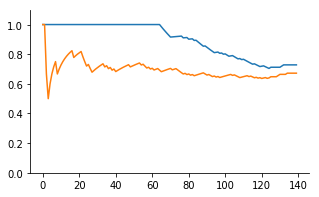

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
df.reset_index(drop=True)['rej_frac_SpatialDE'].plot(ax=ax)
df.reset_index(drop=True)['rej_frac_scGCO'].plot(ax=ax)
ax.set_ylim(0, 1.1)
plt.show()

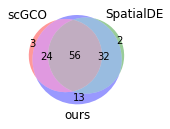

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


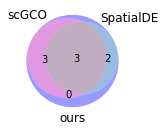

In [15]:
def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_venn3(gsets, ax)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_venn3(neg_sets, ax)
plt.show()

raw data dim: (1056, 140)


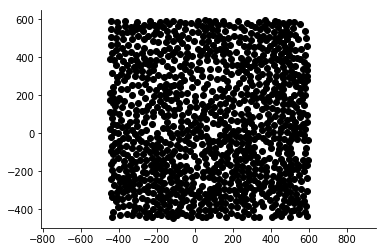

(128,)


In [28]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from main_methods import select_spatial_genes
from matplotlib_venn import venn2,venn3

def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)

    
# load the data for a given replicate
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
locs,data=read_spatial_expression(ff,sep=' ')
data_norm = normalize_count_cellranger(data)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.scatter(*locs.T, c='k')
plt.axis('equal')
plt.show()
alpha= 0.05

# run our method
pvals, rej_idx = select_spatial_genes(locs, data_norm.values, knn=5, alpha=alpha, n_perm=10000)
ours = data.columns[rej_idx]
print(ours.shape)

raw data dim: (1056, 140)


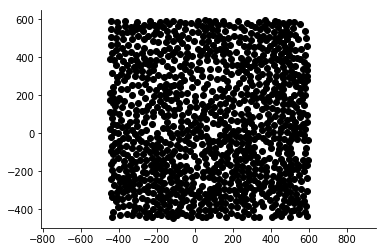

(122,)


In [6]:
fn =  ddir+'/data/MERFISH/our_results/MERFISH_result_df.csv'
save_data_to_file

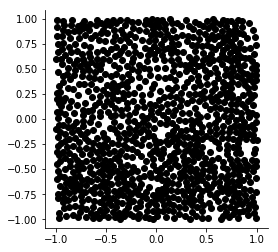

In [7]:
# center the locations to zero and 1
dat = pd.DataFrame(locs, columns=['x', 'y'])
def center_unit(x):
    shift = (max(x) + min(x)) / 2
    scale = (max(x) - min(x)) / 2
    return (x - shift) / scale
dat['x'] = center_unit(dat['x'])
dat['y'] = center_unit(dat['y'])
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(dat['x'], dat['y'], c='k')
plt.axis('equal')
plt.show()

In [8]:
def patterns(name, x, y):
    vals = x ** 2 + y ** 2
    return vals


(140, 1052)
84
91


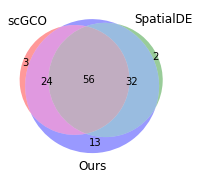

In [25]:

def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plot_venn3(gsets, ax)
plt.show()

In [27]:
for key in gsets:
    gset = gsets[key]
    neg = sorted([g for g in gset if g.startswith('Blank')])
    print('{}: {}'.format(key, neg))

scGCO: ['Blank-1', 'Blank-10', 'Blank-2', 'Blank-4', 'Blank-5', 'Blank-8']
SpatialDE: ['Blank-1', 'Blank-5', 'Blank-6', 'Blank-8', 'Blank-9']
Ours: ['Blank-1', 'Blank-10', 'Blank-2', 'Blank-4', 'Blank-5', 'Blank-6', 'Blank-8', 'Blank-9']
